In [1]:
%%capture
# IMPORTS
import GDI
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.utils import io

In [2]:
# PARAMETERS

# number of nodes
R  = 11

# number of samples
N  = 1e5  

# memory parameter
M  = 3     

# bootstrap iterations
B = 100

# weights/betas
p1 = 0.5
p2 = 0.75
p3 = 0.5
p4 = 0.5
p5 = 0.75

In [3]:
# GENERATE RAW DATA
# X has dim: NxR
X = np.random.multivariate_normal(np.zeros((R,)), np.eye(R), int(N))

In [4]:
# IMPLEMENT CAUSALITY/STRUCTURE
# shift things in time to create causal Gaussian network with weights used before
X[1:,0]  = np.sqrt(1-p1)*X[1:,0]  + np.sqrt(p1)*X[:-1,5]
X[1:,2]  = np.sqrt(1-p1)*X[1:,2]  + np.sqrt(p1)*X[:-1,5]
X[1:,4]  = np.sqrt(1-p1)*X[1:,4]  - np.sqrt(p1)*X[:-1,5]
X[1:,3]  = np.sqrt(1-p2)*X[1:,3]  + np.sqrt(p2)*X[:-1,0]
X[1:,1]  = np.sqrt(1-p3)*X[1:,1]  - np.sqrt(p3/3)*X[:-1,7] + np.sqrt(p3/3)*X[:-1,8] + np.sqrt(p3/3)*X[:-1,5]
X[1:,10] = np.sqrt(1-p4)*X[1:,10] + np.sqrt(p4)*X[:-1,3]
X[1:,9]  = np.sqrt(1-p5)*X[1:, 9] + np.sqrt(p5/2)*X[:-1,4] + np.sqrt(p5/2)*X[:-1,2]

In [5]:
# TRUE CONNECTIVITY
true_connectivity = np.zeros((R,R))
true_connectivity[5,[0, 2, 4,]] = np.asarray([p1, p1, -p1,])
true_connectivity[[5, 8,],1] = p3/3
true_connectivity[7,1] = -p3/3
true_connectivity[[2, 4],9] = p5/2
true_connectivity[0,3] = p2
true_connectivity[3,10] = p4

In [6]:
%%capture
# ESTIMATE DI+GDI
with io.capture_output() as captured:
    X_GDI = GDI.GDI(X,M,B)
    X_DI  = GDI.DI(X,M,B)

# SET ESTIMATES LESS THAN 0 TO 0
X_DI[X_DI<0]=0
X_GDI[X_GDI<0]=0
    
# ESTIMATE SIGNS
X_partial_sign, X_regular_sign = GDI.sign_inference(X,M)

In [7]:
# COMPUTE TRUE VALUES OF GDI
true_GDI = np.zeros((R,R))

true_GDI[5,0]  = 0.5*np.log(1+(p1/(1-p1)))
true_GDI[5,2]  = 0.5*np.log(1+(p1/(1-p1)))
true_GDI[5,4]  = -0.5*np.log(1+(p1/(1-p1)))

true_GDI[5,1]  = 0.5*np.log(1+((p3/4)/(1-p3)))
true_GDI[7,1]  = -0.5*np.log(1+((p3/4)/(1-p3)))
true_GDI[8,1]  = 0.5*np.log(1+((p3/4)/(1-p3)))

true_GDI[2,9] = 0.5*np.log(1+(((p5/2)*(1-p1))/(1-p5)))
true_GDI[4,9] = 0.5*np.log(1+(((p5/2)*(1-p1))/(1-p5)))

true_GDI[0,3]  = 0.5*np.log(1+(((p2)*(1-p1))/(1-p2)))
true_GDI[3,10] = 0.5*np.log(1+(((p4)*(1-p2))/(1-p4)))

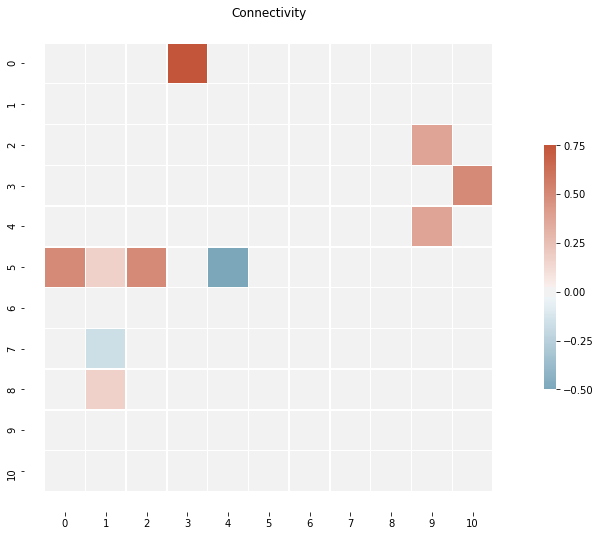

In [13]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the correct aspect ratio
sns.heatmap(true_connectivity, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xlim((-0.5, R+0.5))
plt.ylim((R+0.5,-0.5))
plt.title('Connectivity');

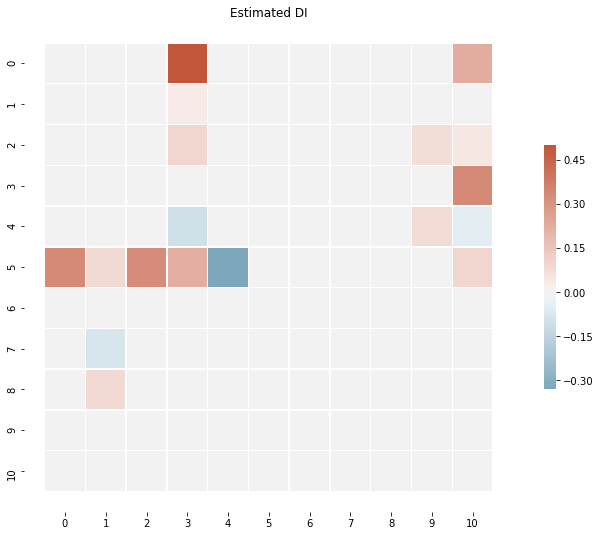

In [14]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the correct aspect ratio
sns.heatmap(X_regular_sign*X_DI, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xlim((-0.5, R+0.5))
plt.ylim((R+0.5,-0.5))
plt.title('Estimated DI');

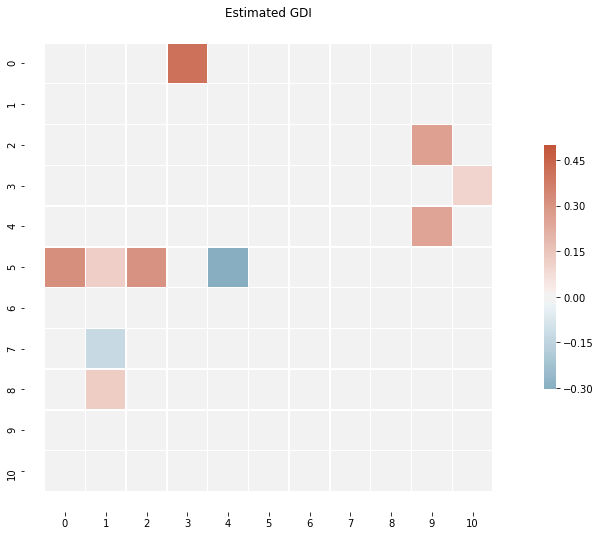

In [15]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the correct aspect ratio
sns.heatmap(X_partial_sign*X_GDI, cmap=cmap, vmax=0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xlim((-0.5, R+0.5))
plt.ylim((R+0.5,-0.5))
plt.title('Estimated GDI');

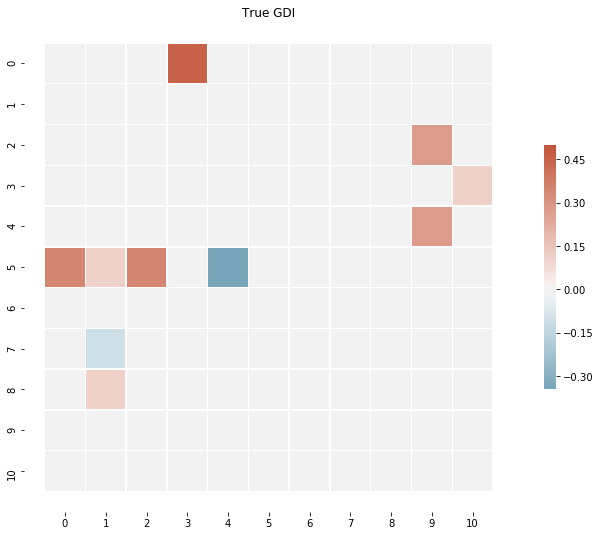

In [16]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the correct aspect ratio
sns.heatmap(true_GDI, cmap=cmap, vmax = 0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xlim((-0.5, R+0.5))
plt.ylim((R+0.5,-0.5))
plt.title('True GDI');